In [101]:
from sklearn import datasets, tree, metrics, ensemble
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import statistics
import einops

In [102]:
##### ustawienia
time_multiplicator = 1
seed = 244810
samples = 2410

In [103]:
def standarize(arr):
    for col in range(arr.shape[1]):
        xmean = np.mean( arr[:,col])
        xstd = np.std( arr[:,col])
        arr[:,col] = (arr[:,col] - xmean)/xstd
    return arr    
    
def normalize(arr):
    for col in range(arr.shape[1]):
        xmin = min( arr[:,col])
        xmax = max( arr[:,col])
        arr[:,col] = ((arr[:,col] - xmin )/(xmax-xmin) )* 2 -1
    
    return arr        

In [104]:
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train = normalize(X_train)
# X_test = normalize(X_test)

In [105]:

class myNeuron():
    def __init__(self, size=2, activationf='heavyside', batch=8):
        self.w = np.random.random(size+1)
        self.batch_size = batch
        
        if activationf == 'heavyside':
            self.activation = self.heavyside
            self.derivative = self.heavyside_der
            
        if activationf == 'logistic':
            self.activation = self.logistic
            self.derivative = self.logistic_der
            
        
    # dodać pozostałe pochodne
    
    def heavyside(self,X):
        return np.heaviside(X,0.5)
    def heavyside_der(self,X):
        return np.ones(X.shape[0])
    
    def logistic(self, X):
        return  1.0/(1+np.exp(-6*X))
    def logistic_der(self, X):
        return self.logistic(X) * (1-self.logistic(X))
    
    def augment(self, X):
        batch_size = X.shape[0]
        return np.c_[X, np.ones(batch_size)* -1.0]
    
    def fit(self, X, y, eta=0.01, epochs = 1):
        samples = X.shape[0]
        n_of_batches = samples - (samples % self.batch_size)
        indexes = np.arange(samples)
        for i in range(epochs):
            np.random.shuffle(indexes)
            X_batched = X[indexes][:n_of_batches]
            y_batched = y[indexes][:n_of_batches]
            
            X_batched = einops.rearrange(X_batched,"(batches size) features -> batches size features",size=self.batch_size)
            y_batched = einops.rearrange(y_batched,"(batches size) -> batches size",size=self.batch_size)

            for X_batch, y_true in zip(X_batched, y_batched):
                
                y_pred = self.predict(X_batch)
                epsilon = y_true - y_pred
                gradient = self.derivative(self.transform(X_batch))
                
                epsilon = einops.rearrange(epsilon,"size -> size 1")
                gradient = einops.rearrange(gradient, "size -> size 1")
                
                delta = eta + epsilon + gradient + self.augment(X_batch)
                
                self.w = np.mean(delta, axis=0)
    
    def predict(self, X):
        return self.activation(self.transform(X))
    
    def transform(self, X):
        X = self.augment(X)
        return X @ self.w
            
        

In [106]:
# model = myNeuron(activationf='logistic')
model = myNeuron()
model.fit(X_train,y_train)

              | Sklearn | Własna  |Różnica
--------------+---------+---------+----------


NameError: name 'sk_cm' is not defined

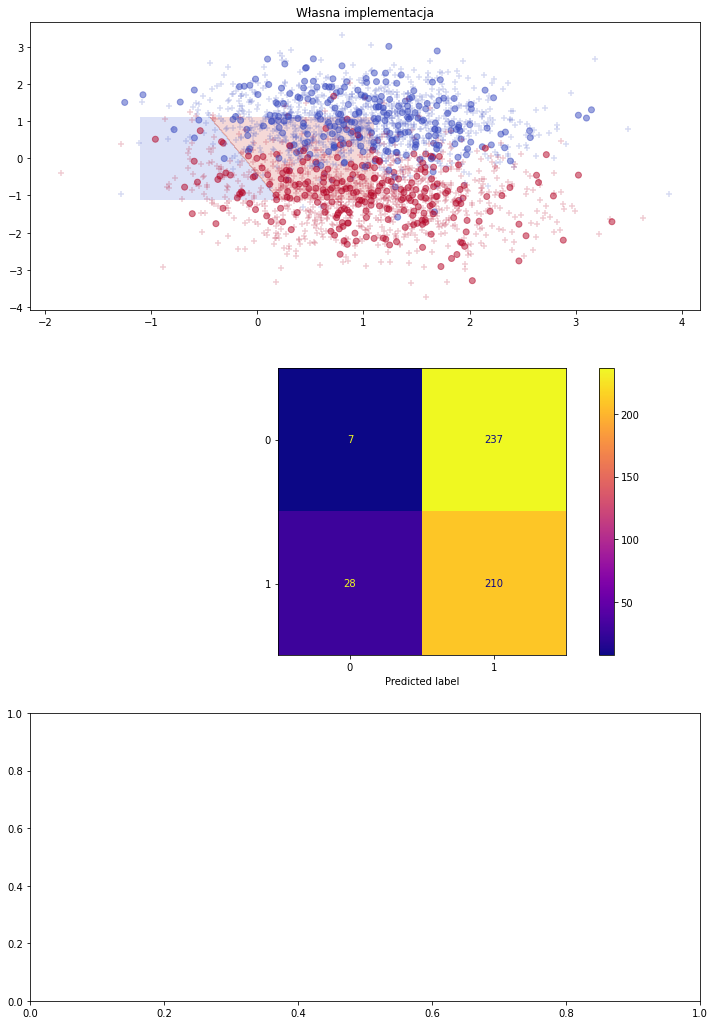

In [107]:
mycmap = "coolwarm"
pred = model.predict(X_test)


#graph
# if roc:
#     fig, axs = plt.subplots(3, 2,figsize=(12,18))
# else: 
#     fig, axs = plt.subplots(2, 2,figsize=(12,12))
# mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]

mesh = np.meshgrid(np.arange(-1.1, 1.1, 0.01), np.arange(-1.1, 1.1, 0.01))[0]
my_predict = np.array(model.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
fig, axs = plt.subplots(3, 1,figsize=(12,18))


axs[0].set_title("Własna implementacja")
axs[0].contourf(mesh, mesh.T, my_predict, alpha=0.2,cmap=mycmap)
axs[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="o", alpha=0.5,cmap=mycmap)
axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker="+", alpha=0.2,cmap=mycmap)

my_cm = metrics.confusion_matrix(y_test, pred)
my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
my_disp.plot(ax=axs[1] ,cmap="plasma")
# my_disp.im_.colorbar.remove()
my_disp.ax_.set_ylabel('')



print('              | Sklearn | Własna  |Różnica')
print('--------------+---------+---------+----------')
print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}|{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):9.4f}|{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0])-my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):9.4f}')
print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][1]+sk_cm[1][1]):9.4f}|{my_cm[1][1]/(my_cm[0][1]+my_cm[1][1]):9.4f}|{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1])-my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]):9.4f}')
print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, y_test):9.4f}|{metrics.accuracy_score(my_pred, y_test):9.4f}|{metrics.accuracy_score(sk_pred, y_test)-metrics.accuracy_score(my_pred, y_test):9.4f}')

print(f'Czas wykonania|{sk_time:9.2E}|{my_time:9.2E}|{my_time/sk_time:9.2E}')


print(f'BACC          |{(sk_cm[1][1]/(sk_cm[0][1]+sk_cm[1][1])+sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]))/2 :9.4f}|{(my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])+my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))/2 :9.4f}|{(sk_cm[1][1]/(sk_cm[0][1]+sk_cm[1][1])+sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]))/2 -(my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])+my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))/2 :9.4f}')



In [63]:
pred

array([0.99989899, 0.99989638, 0.99990535, 0.99990272, 0.99990887,
       0.99991165, 0.9999041 , 0.99989576, 0.99989409, 0.99989936,
       0.99989373, 0.99990697, 0.99989752, 0.99990414, 0.99989285,
       0.99990665, 0.99991146, 0.99990542, 0.99990807, 0.99990539,
       0.99991442, 0.99990639, 0.99991602, 0.99989903, 0.99991133,
       0.99991044, 0.99989858, 0.99991191, 0.99990664, 0.99990889,
       0.99988894, 0.99989446, 0.99991113, 0.99989632, 0.99991023,
       0.99989431, 0.99989955, 0.99990544, 0.99990352, 0.99990386,
       0.99991119, 0.99990471, 0.99991389, 0.99991038, 0.99990491,
       0.99989193, 0.99990215, 0.99990213, 0.99990697, 0.99991692,
       0.99990931, 0.99992021, 0.99990081, 0.99990381, 0.99990269,
       0.99990406, 0.99990435, 0.99991348, 0.99991679, 0.99990155,
       0.99989791, 0.99991089, 0.9999    , 0.9999129 , 0.99991766,
       0.99990101, 0.99990417, 0.99990415, 0.99991326, 0.99991391,
       0.99989671, 0.99991177, 0.99989962, 0.99989861, 0.99989

In [86]:
np.count_nonzero(np.heaviside(X_train, 0.5))

3856

In [90]:
np.count_nonzero(np.heaviside(X_train[:,0], 0.5))

1928

In [93]:
X_train

array([[ 0.23751624, -0.13796789],
       [ 0.00094966, -0.11526826],
       [-0.13812852, -0.29929059],
       ...,
       [ 0.0597643 ,  0.4428283 ],
       [ 0.12156652,  0.46159187],
       [-0.40788995,  0.22706691]])

In [81]:
1.0/(1+np.exp(-6*X_train))

array([[0.97616668, 0.92996139],
       [0.95270267, 0.93426909],
       [0.92992999, 0.89110986],
       ...,
       [0.96004755, 0.98698413],
       [0.96658291, 0.9876878 ],
       [0.85524312, 0.97542637]])